### Dump flash

In [461]:
import serial
import serial.tools.list_ports
import time
import os

# SERIAL_PORT = '/dev/cu.usbmodem0010577597601'  # DK-1
SERIAL_PORT = '/dev/cu.usbmodem0010577391531'  # DK-3


# SERIAL_PORT = '/dev/cu.usbmodem0010577342381'  # DK-5
# SERIAL_PORT = '/dev/cu.usbmodem0010577696461'  # DK-4

BAUDRATE = 1000000

# Check if port exists
if not os.path.exists(SERIAL_PORT):
    print(f"Error: Port {SERIAL_PORT} does not exist!")
    print("\nAvailable serial ports:")
    for port in serial.tools.list_ports.comports():
        print(f"  - {port.device}: {port.description}")
    raise FileNotFoundError(f"Serial port {SERIAL_PORT} not found")

print(f"Connecting to {SERIAL_PORT} at {BAUDRATE} baud...")

try:
    with serial.Serial(SERIAL_PORT, BAUDRATE, timeout=1) as ser:
        # Flush any existing data in buffers
        ser.reset_input_buffer()
        ser.reset_output_buffer()
        time.sleep(0.1)  # Give it a moment to settle
        
        print("Connected! Waiting for data...")
        print("(Make sure the device has started dumping flash)")
        
        with open('raw.txt', 'w') as f:
            end_str = ""
            last_activity = time.time()
            bytes_received = 0
            no_data_count = 0

            while True:
                bytes_to_read = ser.in_waiting

                if bytes_to_read > 0:
                    data = ser.read(bytes_to_read)
                    bytes_received += len(data)
                    last_activity = time.time()
                    no_data_count = 0

                    try:
                        data_str = data.decode('utf-8')
                    except UnicodeDecodeError:
                        # Skip non-UTF8 data but continue
                        continue

                    if data_str:
                        end_str = (end_str + data_str)[-50:].replace('\n', '')
                        f.write(data_str)
                        f.flush()  # Ensure data is written immediately
                        
                        # Print progress every 10KB
                        if bytes_received % 10240 < bytes_to_read:
                            print(f"Received {bytes_received:,} bytes...", end='\r')

                    # Check for completion message
                    if "Dumping flash finished." in end_str:
                        print(f"\nDone! Received {bytes_received:,} bytes total.")
                        print("Done writing to raw.txt.")
                        break
                else:
                    no_data_count += 1
                    # If no data for 10 seconds, print a warning
                    if time.time() - last_activity > 10 and no_data_count == 1:
                        print("\nWarning: No data received for 10 seconds. Is the device still dumping?")
                    
                    # Timeout after 60 seconds of no activity
                    if time.time() - last_activity > 60:
                        print(f"\nTimeout: No data received for 60 seconds.")
                        print(f"Total bytes received: {bytes_received:,}")
                        print("Check if the device is still connected and dumping.")
                        break
                    
                    time.sleep(0.01)  # Small delay to avoid busy-waiting

except serial.SerialException as e:
    print(f"\nError: Could not open serial port {SERIAL_PORT}")
    print(f"Details: {e}")
    print("\nPlease check:")
    print("  1. Is the device connected?")
    print("  2. Is another program using the port? (try: lsof | grep {})".format(SERIAL_PORT))
    print("  3. Try unplugging and replugging the device")
    raise
except KeyboardInterrupt:
    print(f"\n\nInterrupted by user. Total bytes received: {bytes_received:,}")
    raise

Error: Port /dev/cu.usbmodem0010577391531 does not exist!

Available serial ports:
  - /dev/cu.debug-console: n/a
  - /dev/cu.Bluetooth-Incoming-Port: n/a


FileNotFoundError: Serial port /dev/cu.usbmodem0010577391531 not found

### Convert to .wav and readable .txt files

In [427]:
import re
import struct
import wave

SAMPLE_RATE = 8000
CHANNELS = 1
SAMPLE_WIDTH = 3
OUTPUT_NAME = "t25m0p"

with open("raw.txt", "r") as f:
    raw = f.read()

match = re.search(r'Dumping flash...\s*(.*?)\s*Dumping flash finished.', raw, re.DOTALL)

if match:
    byte_data = bytes.fromhex(match.group(1).replace('\n', ''))
    wav_data = b''

    with open(f"{OUTPUT_NAME}.txt", "w") as f:
        for block in range(len(byte_data) // 4096):
            local_ts = struct.unpack('<Q', byte_data[block * 4096: block * 4096 + 8])[0]
            central_ts = struct.unpack('<Q', byte_data[block * 4096 + 8: block * 4096 + 16])[0]
            f.write("local: " + str(local_ts) + " central: " + str(central_ts) + "\n")

            for i in range(1020):
                sample = struct.unpack('<i', byte_data[block * 4096 + 16 + 4 * i: block * 4096 + 16 + 4 * i + 4])[0] >> 8
                f.write(str(sample) + "\n")
                wav_data += struct.pack('<i', sample)[:3]

    with wave.open(f"{OUTPUT_NAME}.wav", 'wb') as wav_file:
        wav_file.setnchannels(CHANNELS)
        wav_file.setsampwidth(SAMPLE_WIDTH)
        wav_file.setframerate(SAMPLE_RATE)
        wav_file.writeframes(wav_data)

    print(f"Done writing to {OUTPUT_NAME}.txt and {OUTPUT_NAME}.wav from {len(byte_data) / (1024 * 1024)} MB of data, resulting in {(len(byte_data) // 4096) * 1020} samples.")

else:
    print("No flash dump found")

Done writing to t25m0p.txt and t25m0p.wav from 1.0 MB of data, resulting in 261120 samples.


### Initialize microphone objects and calculate timestamps

In [459]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, correlation_lags

%matplotlib widget


class Mic:
    """
    A microphone recording.

    Args:
        pos (list): The coordinates of the mic's position. Can be in 2D or 3D.
        file (str): The file name of the converted recording.
    """
    def __init__(self, pos, file):
        self.pos = np.array(pos)

        local_times = []
        central_times = []
        samples = []

        with open(file, 'r') as f:
            for line in f:
                if line.startswith('local:'):
                    local_times.append(int(line.split()[-3]))
                    central_times.append(int(line.split()[-1]))
                else:
                    try:
                        sample = int(line.strip())
                    except ValueError:
                        sample = 0
                    samples.append(sample)

        offsets = np.array(local_times) - np.array(central_times)

        # with synchronization
        timestamps = np.interp(np.arange(0, len(samples)), np.arange(0, len(samples), 1020), central_times)

        # without synchronization 
        # timestamps = np.interp(np.arange(0, len(samples)), np.arange(0, len(samples), 1020), local_times) - offsets[0]

        print(f"Calculated {len(timestamps)} data points for {file}.")
        if np.std(np.diff(local_times)) > 1:
            print("\033[31mWARNING: Timestamps vary more than expected. Data collection was likely flawed.\033[0m")

        print(f"Drift: {offsets[-1] - offsets[0]} us -> {(offsets[-1] - offsets[0]) * 1e6 / (central_times[-1] - central_times[0])} PPM\n")

        self.timestamps = timestamps
        self.data = np.column_stack([timestamps * 1e-6, samples])

    def get_sliced_data(self, t1, t2):
        start_index = np.argmax(self.data[:, 0] > t1)
        end_index = np.argmax(self.data[:, 0] > t2)
        sliced_data = self.data[start_index: end_index, :]
        return sliced_data

    @staticmethod
    def calculate_measured_tdoa(mic1, mic2, source, visualize=False):
        sd1 = mic1.get_sliced_data(source.t1, source.t2)
        sd2 = mic2.get_sliced_data(source.t1, source.t2)
        t1, s1 = sd1[:, 0], sd1[:, 1]
        t2, s2 = sd2[:, 0], sd2[:, 1]

        corr = correlate(s1, s2, mode='full')
        lags = correlation_lags(len(s1), len(s2), mode='full')
        lag = lags[np.argmax(corr)]

        if lag >= 0:
            tdoa = t2[0] - t1[lag]
        else:
            tdoa = t2[-lag] - t1[0]

        if visualize:
            fig, ax = plt.subplots(figsize=(10, 2.5))
            ax.plot(t1, s1, linewidth=0.2)
            ax.plot(t2, s2, linewidth=1)
            ax.plot(t1 + tdoa, s1, linewidth=1, c='tab:blue')
            plt.show()

        limit = (np.linalg.norm(mic1.pos - mic2.pos) - 0.00001) / 343
        return max(min(tdoa, limit), -limit)


class Source:
    """
    A sound source.

    Args:
        pos (list): The coordinates of the source's position. Can be in 2D or 3D.
        t1 (float): The start time of the interval of interest.
        t2 (float): The end time of the interval of interest.
    """
    def __init__(self, pos, t1, t2):
        self.pos = np.array(pos)
        self.t1 = t1
        self.t2 = t2


mics_small = [
    Mic([-0.25, 0.0], "m2_(-30,0)_c.txt"),
    Mic([0.25, 0.0], "m2_(-30,0)_p.txt"), 
]
# mics_linear= [
#     Mic([-1.0, 0.0], "linear_mic0.txt"),
#     Mic([0.0, 0.0], "linear_mic1.txt"), 
#     Mic([1.0, 0.0], "linear_mic2.txt"), 
# ]

Calculated 261120 data points for m2_(-30,0)_c.txt.
Drift: 0 us -> 0.0 PPM

Calculated 261120 data points for m2_(-30,0)_p.txt.
Drift: 170 us -> 5.187376902783248 PPM



### Plot timestamped microphone data

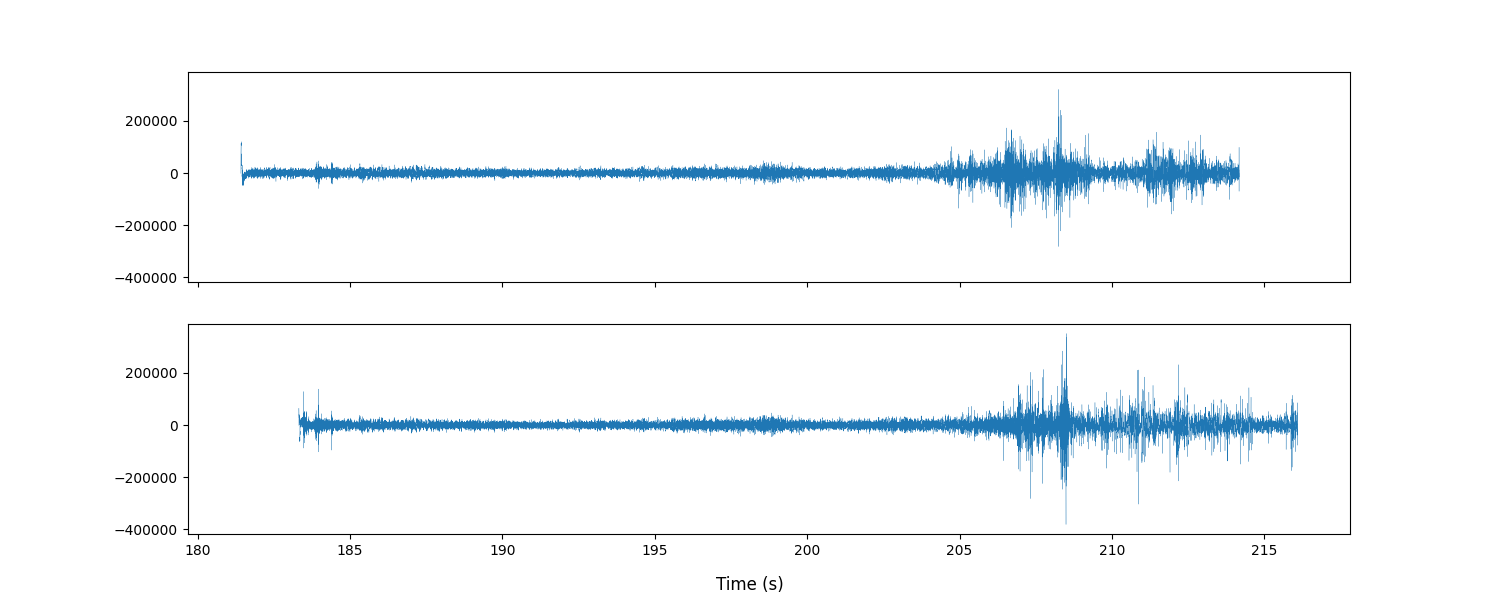

In [460]:
def plot_mics(mics):
    """
    Plots timestamped microphone data.

    Args:
        mics (list): List of mics to plot with a shared time axis.
    """
    fig, axes = plt.subplots(len(mics), 1, figsize=(15, 2 * len(mics) + 2), sharex=True, sharey=True)
    for i in range(len(mics)):
        ax = axes[i] if len(mics) > 1 else axes
        ax.plot(mics[i].data[:, 0], mics[i].data[:, 1], linewidth=0.2)
    fig.supxlabel("Time (s)")


plot_mics(mics_small)
# plot_mics(mics_linear)

### Plot direction estimations (2 mics)

ESTIMATED ANGLES FOR EACH SOURCE:


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/scipy/signal/_signaltools.py:1150: RuntimeWarning: invalid value encountered in log
  fft_ops = 3 * N * np.log(N)  # 3 separate FFTs of size full_out_shape


ValueError: a cannot be empty

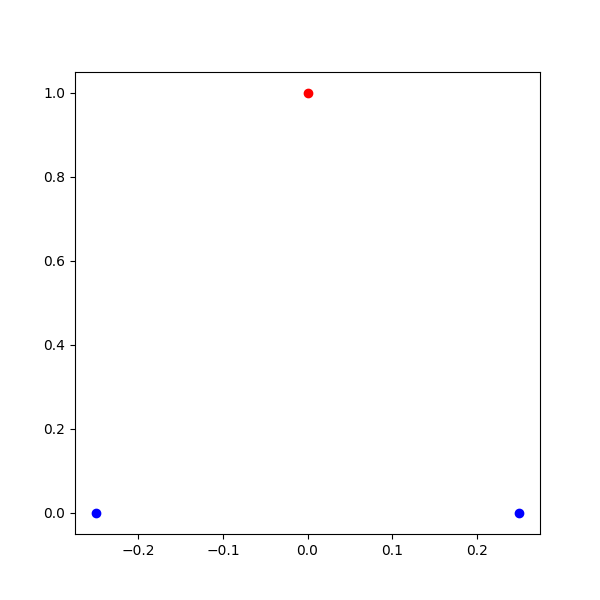

In [386]:
def plot_direction(mics, sources, title="", visualize=False):
    """
    Plots direction estimations (hyperbolas) of sound sources by implementing TDoA for 2 mics.

    Args:
        mics (list): List of 2 mics.
        sources (list): List of sound sources.
        title (str, optional): Title of the resulting graph.
        visualize (bool, optional): Option to visualize cross-correlations for each TDoA calculation.
    """
    mic_positions = np.array([mic.pos for mic in mics])
    source_positions = np.array([source.pos for source in sources])

    fig, ax = plt.subplots(figsize=(6, 6))

    ax.scatter(source_positions[:, 0], source_positions[:, 1], c='red', label='Source')
    ax.scatter(mic_positions[:, 0], mic_positions[:, 1], c='blue', label='Microphones')

    x_vals = np.linspace(-4.5, 4.5, 1000)
    y_vals = np.linspace(-0.5, 10.5, 1000)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Calculate and print estimated angles
    print("="*70)
    print("ESTIMATED ANGLES FOR EACH SOURCE:")
    print("="*70)
    
    mic_separation = np.linalg.norm(mics[1].pos - mics[0].pos)
    
    for i, source in enumerate(sources):
        # Calculate TDoA using cross-correlation
        tdoa = Mic.calculate_measured_tdoa(mics[0], mics[1], source, visualize=visualize)
        
        # Convert TDoA to angle
        # For far-field: sin(θ) = (c × TDoA) / d
        if mic_separation > 0:
            sin_theta = (343 * tdoa) / mic_separation
            sin_theta = np.clip(sin_theta, -1, 1)  # Ensure valid range
            angle = np.arcsin(sin_theta) * 180 / np.pi  # Convert to degrees
        else:
            angle = 0
        
        print(f"Source {i+1} at [{source.pos[0]:.2f}, {source.pos[1]:.2f}]:")
        print(f"  TDoA: {tdoa*1000:.3f} ms")
        print(f"  Estimated angle: {angle:.2f}°")
        print()
        
        # Calculate path difference for hyperbola plotting
        actual_delta_d = tdoa * 343

        d1s = np.sqrt((X - mics[0].pos[0])**2 + (Y - mics[0].pos[1])**2)
        d2s = np.sqrt((X - mics[1].pos[0])**2 + (Y - mics[1].pos[1])**2)
        delta_ds = d2s - d1s

        Z = delta_ds - actual_delta_d
        ax.contour(X, Y, Z, levels=[0], colors='darkseagreen', linewidths=1.5, linestyles='dashed')

    print("="*70)
    print("Note: 0° = straight ahead, positive = left, negative = right")
    print("="*70)
    print()

    ax.set_title(title)
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.legend()
    ax.set_aspect('equal')
    ax.set_axisbelow(True)
    ax.grid(True)
    

sources = [
    Source([0, 1], 44.2, 44.22),
    # Source([-2.0, 4.0], 27.024, 27.034),
    # Source([0.0, 4.0], 30.116, 30.126),
    # Source([2.0, 4.0], 33.133, 33.143),
    # Source([4.0, 4.0], 36.078, 36.088),
]
plot_direction(mics_small, sources, "Two Microphones", visualize=True)

### FFT--> Single Frequency Phase Difference (noise) C6

/var/folders/y6/g2d3qmtj64xcr8wggyb9vj340000gn/T/ipykernel_38796/590157007.py:88: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(peak_freqs_top5, peak_mags_top5, marker, color=marker_color, markersize=8, zorder=5)


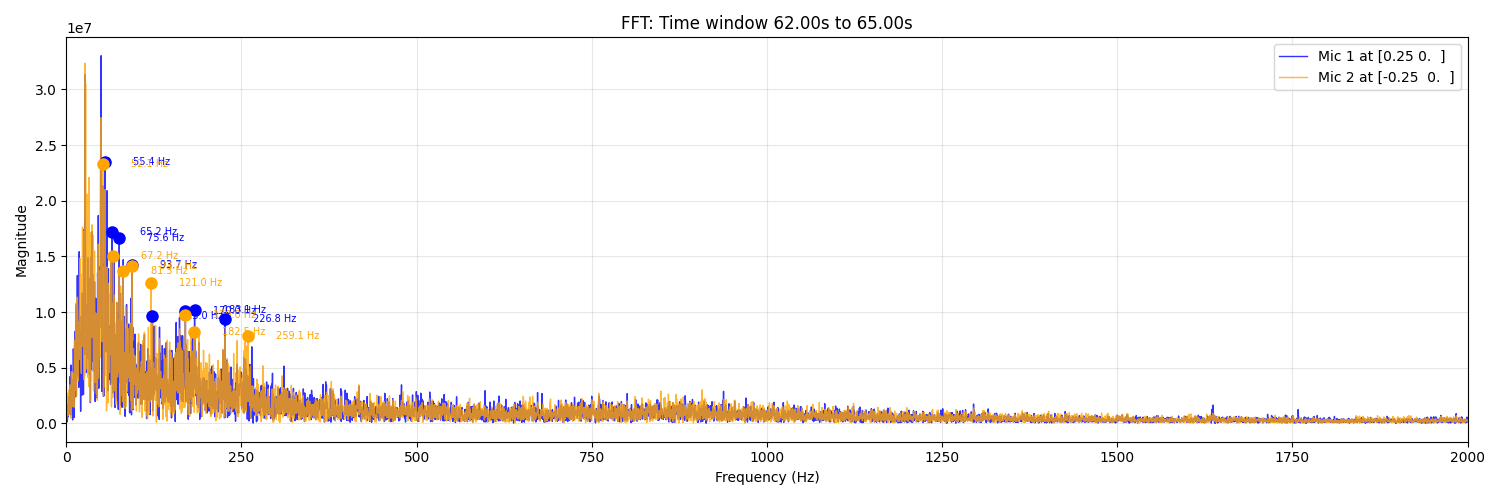

In [ ]:

# compare fft over two windows 


from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

def plot_fft_pair(mic1, mic2, t1, t2, sample_rate=8000):
    """
    Compute and plot FFT for a pair of microphones over a specified time window.
    
    Args:
        mic1: First Mic object
        mic2: Second Mic object
        t1: Start time in seconds
        t2: End time in seconds
        sample_rate: Sample rate in Hz (default 8000)
    """
    # Get data for the specified time window
    sd1 = mic1.get_sliced_data(t1, t2)
    sd2 = mic2.get_sliced_data(t1, t2)
    
    s1 = sd1[:, 1]
    s2 = sd2[:, 1]
    
    # Compute FFT for both mics separately (they may have different lengths)
    fft1 = fft(s1)
    fft2 = fft(s2)
    freqs1 = fftfreq(len(s1), 1/sample_rate)
    freqs2 = fftfreq(len(s2), 1/sample_rate)
    
    # Take only positive frequencies for each mic
    positive_freq_idx1 = freqs1 >= 0
    positive_freq_idx2 = freqs2 >= 0
    
    freqs1_positive = freqs1[positive_freq_idx1]
    freqs2_positive = freqs2[positive_freq_idx2]
    fft1_positive = fft1[positive_freq_idx1]
    fft2_positive = fft2[positive_freq_idx2]
    
    # Compute magnitude spectrum
    magnitude1 = np.abs(fft1_positive)
    magnitude2 = np.abs(fft2_positive)
    
    # Plot both FFTs (they may have slightly different frequency resolutions)
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(freqs1_positive, magnitude1, linewidth=1, label=f'Mic 1 at {mic1.pos}', alpha=0.8, color='blue')
    ax.plot(freqs2_positive, magnitude2, linewidth=1, label=f'Mic 2 at {mic2.pos}', alpha=0.8, color='orange')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.set_title(f'FFT: Time window {t1:.2f}s to {t2:.2f}s')
    ax.set_xlim(0, 2000)  # Focus on audible range
    # ax.set_ylim(0, 20000000)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Find and annotate top 5 peak frequencies for each mic separately
    for i, (freqs_pos, magnitude, label, color) in enumerate([
        (freqs1_positive, magnitude1, 'Mic 1', 'blue'),
        (freqs2_positive, magnitude2, 'Mic 2', 'orange')
    ]):
        mask = (freqs_pos >= 50) & (freqs_pos <= 2000)
        if np.any(mask):
            freqs_masked = freqs_pos[mask]
            mag_masked = magnitude[mask]
            
            # Find peaks using scipy.signal.find_peaks
            # Use a relative height threshold to avoid noise
            height_threshold = np.max(mag_masked) * 0.1  # At least 10% of max
            distance = max(1, len(mag_masked) // 200)  # Minimum distance between peaks
            
            peaks, properties = find_peaks(mag_masked, height=height_threshold, distance=distance)
            
            if len(peaks) > 0:
                # Get peak frequencies and magnitudes
                peak_freqs = freqs_masked[peaks]
                peak_mags = mag_masked[peaks]
                
                # Sort by magnitude and take top 5
                sorted_indices = np.argsort(peak_mags)[::-1]
                top_5_indices = sorted_indices[:8]
                
                peak_freqs_top5 = peak_freqs[top_5_indices]
                peak_mags_top5 = peak_mags[top_5_indices]
                
                # Plot peaks
                marker = 'bo' if i == 0 else 'o'
                marker_color = 'blue' if i == 0 else 'orange'
                ax.plot(peak_freqs_top5, peak_mags_top5, marker, color=marker_color, markersize=8, zorder=5)
                
                # Place labels next to each peak
                x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
                for peak_freq, peak_mag in zip(peak_freqs_top5, peak_mags_top5):
                    # Place label to the right of the peak
                    text_x = peak_freq + x_range * 0.02
                    text_y = peak_mag
                    
                    # Annotate with small label next to peak
                    ax.annotate(f'{peak_freq:.1f} Hz', 
                               xy=(peak_freq, peak_mag), 
                               xytext=(text_x, text_y),
                               fontsize=7, color=color,
                               va='center', ha='left')
    
    plt.tight_layout()
    plt.show()

# Choose which mic pair to analyze and the time window
mic_pair = mics_small  # Change to mics_small or mics_linear
mic1_idx = 0  # First mic index
mic2_idx = 1  # Second mic index

# Choose time window (in seconds)
t_start = 62  # Start time
t_end = 65

# Plot FFT
plot_fft_pair(mic_pair[mic1_idx], mic_pair[mic2_idx], t_start, t_end, SAMPLE_RATE)


### FFT--> Single Frequency Phase Difference (drone) C7

/var/folders/y6/g2d3qmtj64xcr8wggyb9vj340000gn/T/ipykernel_38796/4209957626.py:88: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(peak_freqs_top5, peak_mags_top5, marker, color=marker_color, markersize=8, zorder=5)


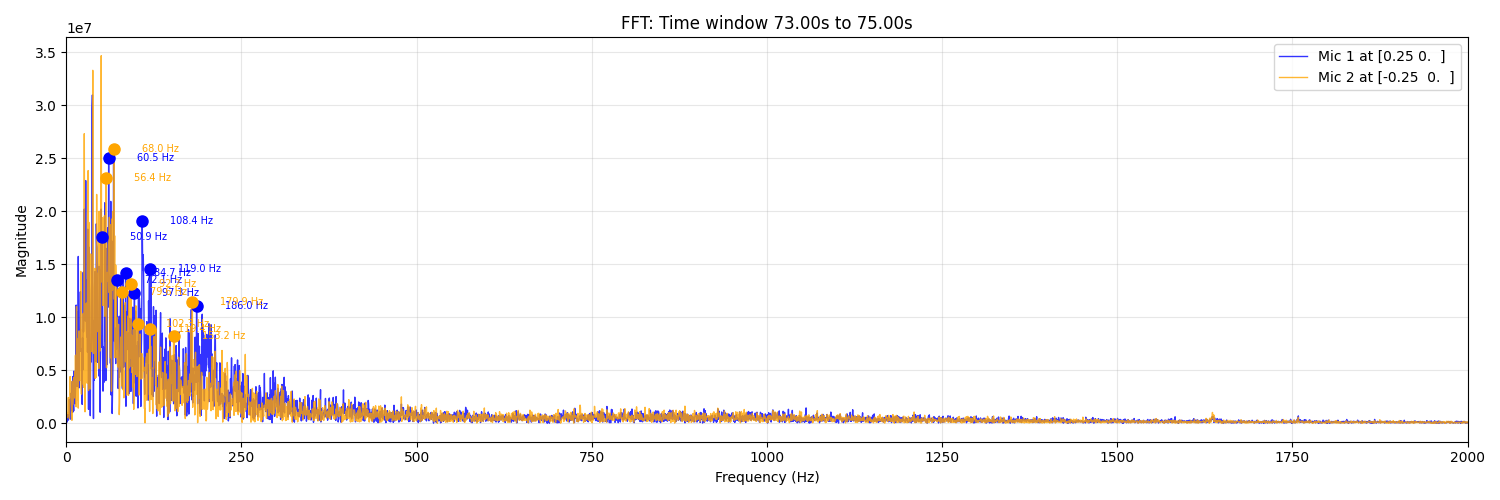

In [ ]:

# compare fft over two windows 


from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

def plot_fft_pair(mic1, mic2, t1, t2, sample_rate=8000):
    """
    Compute and plot FFT for a pair of microphones over a specified time window.
    
    Args:
        mic1: First Mic object
        mic2: Second Mic object
        t1: Start time in seconds
        t2: End time in seconds
        sample_rate: Sample rate in Hz (default 8000)
    """
    # Get data for the specified time window
    sd1 = mic1.get_sliced_data(t1, t2)
    sd2 = mic2.get_sliced_data(t1, t2)
    
    s1 = sd1[:, 1]
    s2 = sd2[:, 1]
    
    # Compute FFT for both mics separately (they may have different lengths)
    fft1 = fft(s1)
    fft2 = fft(s2)
    freqs1 = fftfreq(len(s1), 1/sample_rate)
    freqs2 = fftfreq(len(s2), 1/sample_rate)
    
    # Take only positive frequencies for each mic
    positive_freq_idx1 = freqs1 >= 0
    positive_freq_idx2 = freqs2 >= 0
    
    freqs1_positive = freqs1[positive_freq_idx1]
    freqs2_positive = freqs2[positive_freq_idx2]
    fft1_positive = fft1[positive_freq_idx1]
    fft2_positive = fft2[positive_freq_idx2]
    
    # Compute magnitude spectrum
    magnitude1 = np.abs(fft1_positive)
    magnitude2 = np.abs(fft2_positive)
    
    # Plot both FFTs (they may have slightly different frequency resolutions)
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(freqs1_positive, magnitude1, linewidth=1, label=f'Mic 1 at {mic1.pos}', alpha=0.8, color='blue')
    ax.plot(freqs2_positive, magnitude2, linewidth=1, label=f'Mic 2 at {mic2.pos}', alpha=0.8, color='orange')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.set_title(f'FFT: Time window {t1:.2f}s to {t2:.2f}s')
    ax.set_xlim(0, 2000)  # Focus on audible range
    # ax.set_ylim(0, 20000000)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Find and annotate top 5 peak frequencies for each mic separately
    for i, (freqs_pos, magnitude, label, color) in enumerate([
        (freqs1_positive, magnitude1, 'Mic 1', 'blue'),
        (freqs2_positive, magnitude2, 'Mic 2', 'orange')
    ]):
        mask = (freqs_pos >= 50) & (freqs_pos <= 2000)
        if np.any(mask):
            freqs_masked = freqs_pos[mask]
            mag_masked = magnitude[mask]
            
            # Find peaks using scipy.signal.find_peaks
            # Use a relative height threshold to avoid noise
            height_threshold = np.max(mag_masked) * 0.1  # At least 10% of max
            distance = max(1, len(mag_masked) // 200)  # Minimum distance between peaks
            
            peaks, properties = find_peaks(mag_masked, height=height_threshold, distance=distance)
            
            if len(peaks) > 0:
                # Get peak frequencies and magnitudes
                peak_freqs = freqs_masked[peaks]
                peak_mags = mag_masked[peaks]
                
                # Sort by magnitude and take top 5
                sorted_indices = np.argsort(peak_mags)[::-1]
                top_5_indices = sorted_indices[:8]
                
                peak_freqs_top5 = peak_freqs[top_5_indices]
                peak_mags_top5 = peak_mags[top_5_indices]
                
                # Plot peaks
                marker = 'bo' if i == 0 else 'o'
                marker_color = 'blue' if i == 0 else 'orange'
                ax.plot(peak_freqs_top5, peak_mags_top5, marker, color=marker_color, markersize=8, zorder=5)
                
                # Place labels next to each peak
                x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
                for peak_freq, peak_mag in zip(peak_freqs_top5, peak_mags_top5):
                    # Place label to the right of the peak
                    text_x = peak_freq + x_range * 0.02
                    text_y = peak_mag
                    
                    # Annotate with small label next to peak
                    ax.annotate(f'{peak_freq:.1f} Hz', 
                               xy=(peak_freq, peak_mag), 
                               xytext=(text_x, text_y),
                               fontsize=7, color=color,
                               va='center', ha='left')
    
    plt.tight_layout()
    plt.show()

# Choose which mic pair to analyze and the time window
mic_pair = mics_small  # Change to mics_small or mics_linear
mic1_idx = 0  # First mic index
mic2_idx = 1  # Second mic index

# Choose time window (in seconds)
t_start = 73  # Start time
t_end = 75 # End time

# Plot FFT
plot_fft_pair(mic_pair[mic1_idx], mic_pair[mic2_idx], t_start, t_end, SAMPLE_RATE)


### Compare frequencies and extract unique C8

Target frequency: 206.0 Hz
Phase difference: 2.1959 radians (125.82 degrees)
Angle: 2.1959 radians (125.82 degrees)


### Calculate angle for each frequency C9

In [451]:
### Group unique frequencies into clusters and calculate GCC-PHAT angles

from scipy.fft import fft, ifft
from scipy.signal import butter, filtfilt

# ============================================================================
# INPUT: Time range for GCC-PHAT analysis
# ============================================================================
t_start = 125 # Start time in seconds
t_end = 133 # End time in seconds

# ============================================================================
# INPUT: Frequency range for GCC-PHAT analysis
# ============================================================================
freq_min = 40      # Minimum frequency (Hz)
freq_max = 42   # Maximum frequency (Hz)
use_filter = False  # Set True to apply bandpass filter, False for full spectrum
# ============================================================================

# ============================================================================

def build_frequency_mask_from_peaks(peak_frequencies, n_fft, sample_rate, 
                                     n_bins_per_peak=5, top_k=40):
    """
    Build a binary frequency mask from peak frequencies for masked PHAT.
    
    Args:
        peak_frequencies: Array of peak frequencies in Hz
        n_fft: FFT size (after zero-padding)
        sample_rate: Sample rate in Hz
        n_bins_per_peak: Number of FFT bins to include around each peak (±n_bins/2)
        top_k: Maximum number of peaks to include (select by frequency, top K)
    
    Returns:
        freq_mask: Binary mask array of length n_fft (1 for included bins, 0 otherwise)
    """
    if len(peak_frequencies) == 0:
        return None
    
    # Convert frequencies to FFT bin indices
    freq_resolution = sample_rate / n_fft
    peak_bins = np.round(peak_frequencies / freq_resolution).astype(int)
    
    # Merge near-duplicates (within ±1 FFT bin)
    unique_bins = []
    for bin_idx in np.sort(peak_bins):
        if len(unique_bins) == 0 or bin_idx > unique_bins[-1] + 1:
            unique_bins.append(bin_idx)
    
    # Select top K peaks (by frequency, assuming sorted)
    if len(unique_bins) > top_k:
        unique_bins = unique_bins[:top_k]
    
    # Build mask: include ±n_bins_per_peak/2 bins around each peak
    mask = np.zeros(n_fft, dtype=float)
    half_window = n_bins_per_peak // 2
    
    for bin_idx in unique_bins:
        start_bin = max(0, bin_idx - half_window)
        end_bin = min(n_fft, bin_idx + half_window + 1)
        mask[start_bin:end_bin] = 1.0
    
    return mask


def cluster_frequencies(frequencies, eps=20.0):
    """
    Simple clustering algorithm to group frequencies that are close together.
    Groups frequencies within eps distance of each other.
    
    Args:
        frequencies: Sorted array of frequencies
        eps: Maximum distance between frequencies in the same cluster (Hz)
    
    Returns:
        clusters: List of lists, where each inner list contains frequencies in a cluster
    """
    if len(frequencies) == 0:
        return []
    
    clusters = []
    current_cluster = [frequencies[0]]
    
    for freq in frequencies[1:]:
        # If this frequency is close to the last one in current cluster, add it
        if freq - current_cluster[-1] <= eps:
            current_cluster.append(freq)
        else:
            # Start a new cluster
            clusters.append(current_cluster)
            current_cluster = [freq]
    
    # Don't forget the last cluster
    clusters.append(current_cluster)
    
    return clusters

def group_frequencies_into_bands(frequencies, bandwidth=5.0):
    """
    Group frequencies within a specified bandwidth into bands.
    
    Args:
        frequencies: Array of frequencies to group
        bandwidth: Maximum frequency difference within a band (Hz)
    
    Returns:
        bands: List of tuples (min_freq, max_freq) for each band
    """
    if len(frequencies) == 0:
        return []
    
    sorted_freqs = np.sort(frequencies)
    bands = []
    current_band_start = sorted_freqs[0]
    current_band_end = sorted_freqs[0]
    
    for freq in sorted_freqs[1:]:
        if freq - current_band_end <= bandwidth:
            # Extend current band
            current_band_end = freq
        else:
            # Start new band
            bands.append((current_band_start, current_band_end))
            current_band_start = freq
            current_band_end = freq
    
    # Don't forget the last band
    bands.append((current_band_start, current_band_end))
    
    return bands


def calculate_tdoa_gcc_plain(mic1, mic2, t1, t2, sample_rate=8000, debug=False):
    """
    Plain GCC (no PHAT normalization) for testing.
    Returns TDoA without PHAT phase transform.
    """
    sd1 = mic1.get_sliced_data(t1, t2)
    sd2 = mic2.get_sliced_data(t1, t2)
    s1 = sd1[:, 1]
    s2 = sd2[:, 1]
    
    n1, n2 = len(s1), len(s2)
    n_fft = max(n1, n2)
    n_padded = 2 * n_fft  # Zero-pad to 2N to avoid circular correlation
    
    s1_padded = np.pad(s1, (0, n_padded - n1))
    s2_padded = np.pad(s2, (0, n_padded - n2))
    
    fft1 = fft(s1_padded)
    fft2 = fft(s2_padded)
    
    # Plain GCC: just cross-spectrum, no normalization
    cross_spectrum = fft1 * np.conj(fft2)
    
    # IFFT to get correlation
    corr = np.real(ifft(cross_spectrum))
    
    # Calculate physical lag range
    mic_separation = np.linalg.norm(mic2.pos - mic1.pos)
    max_tdoa = mic_separation / 343.0
    max_lag_samples = int(np.ceil(max_tdoa * sample_rate))
    
    # Convert circular correlation to signed lags
    n_corr = len(corr)
    signed_lags = np.where(np.arange(n_corr) > n_corr // 2,
                          np.arange(n_corr) - n_corr,
                          np.arange(n_corr))
    
    # Constrain to physical range
    valid_mask = np.abs(signed_lags) <= max_lag_samples
    corr_valid = corr.copy()
    corr_valid[~valid_mask] = -np.inf
    
    peak_idx = np.argmax(np.abs(corr_valid))
    lag_samples_peak = signed_lags[peak_idx]
    tdoa = lag_samples_peak / sample_rate
    tdoa = np.clip(tdoa, -max_tdoa, max_tdoa)
    
    if debug:
        print(f"  [GCC-PLAIN] nfft={n_fft}, n_padded={n_padded}, peak_idx={peak_idx}, "
              f"signed_lag={lag_samples_peak}, tau={tdoa*1000:.3f} ms")
    
    return tdoa


def calculate_tdoa_gcc_phat_band(mic1, mic2, freq_min, freq_max, t1, t2, sample_rate=8000, 
                                   debug=False, apply_filter=True, freq_mask=None):
    """
    Calculate TDoA using GCC-PHAT on a specific frequency band (or full spectrum if filter disabled).
    
    FIXED VERSION with proper zero-padding and lag conversion.
    
    Args:
        mic1: First Mic object
        mic2: Second Mic object
        freq_min: Minimum frequency of the band (Hz) - ignored if apply_filter=False
        freq_max: Maximum frequency of the band (Hz) - ignored if apply_filter=False
        t1: Start time in seconds
        t2: End time in seconds
        sample_rate: Sample rate in Hz (default 8000)
        debug: Print debug information (default False)
        apply_filter: Whether to apply bandpass filter (default True). Set False for full spectrum.
    
    Returns:
        tdoa: Time difference of arrival in seconds
        angle: Estimated angle in degrees
    """
    sd1 = mic1.get_sliced_data(t1, t2)
    sd2 = mic2.get_sliced_data(t1, t2)
    s1 = sd1[:, 1]
    s2 = sd2[:, 1]
    
    # Get signals
    s1_filtered = s1
    s2_filtered = s2
    
    # Get signal lengths
    n1, n2 = len(s1_filtered), len(s2_filtered)
    n_fft = max(n1, n2)
    
    # Zero-pad to 2× FFT size to avoid circular correlation
    n_padded = 2 * n_fft
    s1_padded = np.pad(s1_filtered, (0, n_padded - n1))
    s2_padded = np.pad(s2_filtered, (0, n_padded - n2))
    
    # Compute FFT
    fft1 = fft(s1_padded)
    fft2 = fft(s2_padded)
    
    # GCC-PHAT: Cross-spectrum
    # G[k] = X1[k] * conj(X2[k])
    cross_spectrum = fft1 * np.conj(fft2)
    
    # Apply frequency mask if provided (masked PHAT)
    if freq_mask is not None:
        if len(freq_mask) != len(cross_spectrum):
            if debug:
                print(f"  DEBUG: Mask length mismatch: {len(freq_mask)} vs {len(cross_spectrum)}")
            freq_mask = None  # Fall back to full spectrum
        else:
            cross_spectrum = cross_spectrum * freq_mask
    
    # PHAT normalization: G[k] /= (abs(G[k]) + epsilon)
    magnitude = np.abs(cross_spectrum)
    epsilon = 1e-10
    magnitude[magnitude < epsilon] = epsilon
    cross_spectrum_phat = cross_spectrum / magnitude
    
    # IFFT to get correlation
    corr_complex = ifft(cross_spectrum_phat)
    corr = np.real(corr_complex)
    
    # Calculate physical lag range
    mic_separation = np.linalg.norm(mic2.pos - mic1.pos)
    max_tdoa = mic_separation / 343.0
    max_lag_samples = int(np.ceil(max_tdoa * sample_rate))
    
    # Convert circular correlation to signed lags
    # For IFFT of length n: indices [0, 1, ..., n/2-1, -n/2, ..., -1]
    n_corr = len(corr)
    lag = np.arange(n_corr)
    # Convert to signed lag: if lag > n/2, subtract n
    signed_lags = np.where(lag > n_corr // 2, lag - n_corr, lag)
    
    # Constrain search to physically valid range
    valid_mask = np.abs(signed_lags) <= max_lag_samples
    if not np.any(valid_mask):
        if debug:
            print(f"  DEBUG: No valid lags in range ±{max_lag_samples}")
        return None, None, 0.0  # Invalid
    
    # Extract valid correlation values
    corr_valid = corr[valid_mask].copy()
    lags_valid = signed_lags[valid_mask]
    
    # Find peak and compute confidence
    abs_corr_valid = np.abs(corr_valid)
    peak_idx_valid = np.argmax(abs_corr_valid)
    peak_value = abs_corr_valid[peak_idx_valid]
    
    # Compute mean background (exclude peak)
    background_mask = np.ones(len(abs_corr_valid), dtype=bool)
    background_mask[peak_idx_valid] = False
    mean_background = np.mean(abs_corr_valid[background_mask]) if np.any(background_mask) else 0.0
    
    # Confidence = peak / mean_background
    confidence = peak_value / (mean_background + epsilon) if mean_background > 0 else 0.0
    
    # Compute peakiness = peak / second_peak
    abs_corr_sorted = np.sort(abs_corr_valid)[::-1]
    second_peak = abs_corr_sorted[1] if len(abs_corr_sorted) > 1 else epsilon
    peakiness = peak_value / (second_peak + epsilon)
    
    # Confidence thresholds
    confidence_threshold = 3.0
    peakiness_threshold = 1.2
    
    if confidence < confidence_threshold or peakiness < peakiness_threshold:
        if debug:
            print(f"  DEBUG: Low confidence: conf={confidence:.2f}, peakiness={peakiness:.2f}")
        return None, None, confidence  # Invalid - reject
    
    # Get the actual peak index in full correlation array
    lag_samples_peak = lags_valid[peak_idx_valid]
    
    # Find the original index for this lag
    peak_idx = np.where(signed_lags == lag_samples_peak)[0][0]
    
    # Convert to time
    tdoa = lag_samples_peak / sample_rate
    
    if debug:
        print(f"  DEBUG: n_fft={n_fft}, n_padded={n_padded}, peak_idx={peak_idx}, "
              f"signed_lag={lag_samples_peak}, tau={tdoa*1000:.3f} ms")
        print(f"  DEBUG: confidence={confidence:.2f}, peakiness={peakiness:.2f}, "
              f"peak={peak_value:.6f}, background={mean_background:.6f}")
    
    # Calculate angle
    if mic_separation > 0:
        sin_theta = (343.0 * tdoa) / mic_separation
        sin_theta = np.clip(sin_theta, -1.0, 1.0)
        angle = np.arcsin(sin_theta) * 180.0 / np.pi
    else:
        angle = 0.0
    
    return tdoa, angle, confidence


# ============================================================================
# SYNTHETIC TEST: Verify GCC-PHAT can recover known delays
# ============================================================================
print("="*70)
print("SYNTHETIC TEST: Verifying GCC-PHAT implementation")
print("="*70)

# Create synthetic signals with known delay
sample_rate = 8000
duration = 0.1  # 100ms
n_samples = int(sample_rate * duration)
t = np.arange(n_samples) / sample_rate

# Known delay: 8 samples (should match ~1.0 ms at 8 kHz)
known_delay_samples = 8

# Generate broadband test signal (chirp) - better for PHAT
np.random.seed(42)
x_chirp = np.sin(2 * np.pi * (100 + 500*t) * t)  # Chirp 100-600 Hz
# Add some noise for realism
x_chirp += 0.1 * np.random.randn(n_samples)
y_chirp = np.pad(x_chirp, (known_delay_samples, 0))[:n_samples]

# Also create white noise for plain GCC test
x_noise = np.random.randn(n_samples)
y_noise = np.pad(x_noise, (known_delay_samples, 0))[:n_samples]

# Create dummy Mic objects for testing
class DummyMic:
    def __init__(self, pos, data):
        self.pos = np.array(pos)
        self.data = data
    
    def get_sliced_data(self, t1, t2):
        time_array = np.arange(len(self.data)) / sample_rate
        indices = (time_array >= t1) & (time_array < t2)
        return np.column_stack([time_array[indices], self.data[indices]])

mic1_noise = DummyMic([0, 0], x_noise)
mic2_noise = DummyMic([0.5, 0], y_noise)
mic1_chirp = DummyMic([0, 0], x_chirp)
mic2_chirp = DummyMic([0.5, 0], y_chirp)

expected_tdoa = known_delay_samples / sample_rate

# Test 1: Plain GCC (no PHAT normalization) - must recover 8 ± 1 samples
print(f"\n[TEST 1] Plain GCC (no PHAT) with white noise:")
print(f"Testing with known delay: {known_delay_samples} samples ({known_delay_samples/sample_rate*1000:.3f} ms)")
tdoa_plain = calculate_tdoa_gcc_plain(mic1_noise, mic2_noise, 0, duration, 
                                       sample_rate=sample_rate, debug=True)
error_plain = abs(tdoa_plain - expected_tdoa) * sample_rate
print(f"  Expected: {expected_tdoa*1000:.3f} ms ({known_delay_samples} samples)")
print(f"  Recovered: {tdoa_plain*1000:.3f} ms ({tdoa_plain*sample_rate:.1f} samples)")
print(f"  Error: {error_plain:.2f} samples")
if error_plain < 1.0:
    print(f"  ✓ PLAIN GCC PASSED: Error < 1 sample")
else:
    print(f"  ✗ PLAIN GCC FAILED: Error >= 1 sample")

# Test 2: PHAT with broadband chirp
print(f"\n[TEST 2] GCC-PHAT with broadband chirp:")
result_phat = calculate_tdoa_gcc_phat_band(
    mic1_chirp, mic2_chirp, freq_min, freq_max, 0, duration, 
    sample_rate=sample_rate, debug=True, apply_filter=use_filter, freq_mask=None
)
if result_phat[0] is not None:
    tdoa_phat, angle_phat, conf_phat = result_phat
    error_phat = abs(tdoa_phat - expected_tdoa) * sample_rate
    print(f"  Expected: {expected_tdoa*1000:.3f} ms ({known_delay_samples} samples)")
    print(f"  Recovered: {tdoa_phat*1000:.3f} ms ({tdoa_phat*sample_rate:.1f} samples), confidence={conf_phat:.2f}")
    print(f"  Error: {error_phat:.2f} samples")
    if error_phat < 1.0:
        print(f"  ✓ PHAT PASSED: Error < 1 sample, confidence={conf_phat:.2f}")
    else:
        print(f"  ✗ PHAT FAILED: Error >= 1 sample")
else:
    print(f"  ✗ PHAT REJECTED: Low confidence (correlation too flat)")

print("="*70)
print()

# ============================================================================
# Get unique frequencies from previous cell
# ============================================================================
# (This assumes unique_freqs was calculated in the previous cell)
if 'unique_freqs' not in globals() or len(unique_freqs) == 0:
    print("Error: unique_freqs not found. Please run the previous cell first.")
else:
    # Group frequencies into clusters using simple clustering algorithm
    # Clusters frequencies that are within 20 Hz of each other
    sorted_freqs = np.sort(unique_freqs)
    if len(sorted_freqs) > 0:
        # Use simple clustering to group frequencies within 20 Hz of each other
        clusters = cluster_frequencies(sorted_freqs, eps=20.0)
        
        # Create bands from clusters (min to max frequency in each cluster)
        bands = []
        for cluster in clusters:
            if len(cluster) > 0:
                bands.append((min(cluster), max(cluster)))
        
        # If we have more than 4 clusters, take the 4 largest by frequency span
        if len(bands) > 4:
            # Sort clusters by size (frequency span) and take the 4 largest
            cluster_sizes = [(max(cluster) - min(cluster), (min(cluster), max(cluster))) 
                            for cluster in clusters]
            cluster_sizes.sort(reverse=True, key=lambda x: x[0])
            bands = [band for _, band in cluster_sizes[:4]]
        elif len(bands) < 4 and len(bands) > 0:
            # If we have fewer than 4 clusters, that's fine - just use what we have
            pass
    else:
        bands = []
    
    print("="*70)
    print(f"FREQUENCY CLUSTERS ({len(bands)} clusters from {len(unique_freqs)} frequencies):")
    print("="*70)
    print()
    
    # Use the input time range for angle calculations
    calc_t1 = t_start
    calc_t2 = t_end
    
    band_results = []
    
    # Get signal length for mask building
    sd1_temp = mics_small[0].get_sliced_data(calc_t1, calc_t2)
    n1_temp = len(sd1_temp[:, 1])
    n_fft_temp = max(n1_temp, len(mics_small[1].get_sliced_data(calc_t1, calc_t2)[:, 1]))
    n_padded_temp = 2 * n_fft_temp  # Match the zero-padding used in calculate_tdoa_gcc_phat_band
    
    # Build frequency mask from unique frequencies (masked PHAT)
    freq_mask = build_frequency_mask_from_peaks(unique_freqs, n_padded_temp, SAMPLE_RATE, 
                                                 n_bins_per_peak=5, top_k=40)
    
    # Test 1: Full spectrum (no masking) for baseline
    print("\nTesting with FULL SPECTRUM (no masking) for baseline:")
    print("-" * 70)
    result_full = calculate_tdoa_gcc_phat_band(
        mics_small[0], mics_small[1], freq_min, freq_max, calc_t1, calc_t2, 
        SAMPLE_RATE, debug=True, apply_filter=use_filter, freq_mask=None
    )
    if result_full[0] is not None:
        tdoa_full, angle_full, conf_full = result_full
        print(f"Full spectrum: TDoA = {tdoa_full*1000:.3f} ms, Angle = {angle_full:.2f}°, Confidence = {conf_full:.2f}")
    else:
        print("Full spectrum: REJECTED (low confidence)")
    print("=" * 70)
    print()
    
    # Test 2: Masked PHAT using peak frequencies
    print("Testing with MASKED PHAT (using peak frequencies):")
    print("-" * 70)
    result_masked = calculate_tdoa_gcc_phat_band(
        mics_small[0], mics_small[1], freq_min, freq_max, calc_t1, calc_t2,
        SAMPLE_RATE, debug=True, apply_filter=use_filter, freq_mask=freq_mask
    )
    if result_masked[0] is not None:
        tdoa_masked, angle_masked, conf_masked = result_masked
        print(f"Masked PHAT: TDoA = {tdoa_masked*1000:.3f} ms, Angle = {angle_masked:.2f}°, Confidence = {conf_masked:.2f}")
    else:
        print("Masked PHAT: REJECTED (low confidence)")
    print("=" * 70)
    print()
    
    # Test 3: Cluster-based masked PHAT (one mask per cluster)
    print("Testing with CLUSTER-BASED MASKED PHAT:")
    print("-" * 70)
    
    for i, (freq_min, freq_max) in enumerate(bands, 1):
        # Get frequencies in this cluster
        cluster_freqs = sorted_freqs[(sorted_freqs >= freq_min) & (sorted_freqs <= freq_max)]
        
        if len(cluster_freqs) == 0:
            continue
        
        # Build mask for this cluster
        cluster_mask = build_frequency_mask_from_peaks(cluster_freqs, n_padded_temp, SAMPLE_RATE,
                                                       n_bins_per_peak=5, top_k=len(cluster_freqs))
        
        # Calculate GCC-PHAT with mask
        result = calculate_tdoa_gcc_phat_band(
            mics_small[0], mics_small[1], freq_min, freq_max,
            calc_t1, calc_t2, SAMPLE_RATE,
            debug=False, apply_filter=False, freq_mask=cluster_mask
        )
        
        if result[0] is not None:
            tdoa, angle, confidence = result
            band_results.append({
                'band_num': i,
                'freq_min': freq_min,
                'freq_max': freq_max,
                'band_range': f"{freq_min:.2f}-{freq_max:.2f}",
                'tdoa': tdoa,
                'angle': angle,
                'confidence': confidence
            })
            print(f"Cluster {i}: {freq_min:.2f}-{freq_max:.2f} Hz")
            print(f"  TDoA: {tdoa*1000:.3f} ms, Angle: {angle:.2f}°, Confidence: {confidence:.2f}")
        else:
            print(f"Cluster {i}: {freq_min:.2f}-{freq_max:.2f} Hz - REJECTED (low confidence)")
        print()
    
    print("="*70)
    
    # Calculate statistics on valid results (confidence-weighted)
    if len(band_results) > 0:
        angles = np.array([r['angle'] for r in band_results])
        tdoas = np.array([r['tdoa'] for r in band_results])
        confidences = np.array([r.get('confidence', 1.0) for r in band_results])
        
        # Confidence-weighted average
        weights = confidences / np.sum(confidences)
        weighted_avg_angle = np.average(angles, weights=weights)
        weighted_avg_tdoa = np.average(tdoas, weights=weights)
        
        print(f"\n{'='*70}")
        print(f"ANGLE STATISTICS (from {len(band_results)} valid clusters):")
        print(f"Time window: {calc_t1:.2f}s to {calc_t2:.2f}s")
        print("="*70)
        print(f"  Mean angle:              {np.mean(angles):.2f}°")
        print(f"  Median angle:            {np.median(angles):.2f}°")
        print(f"  Std deviation:           {np.std(angles):.2f}°")
        print(f"  Confidence-weighted avg: {weighted_avg_angle:.2f}°")
        print(f"  Weighted avg TDoA:       {weighted_avg_tdoa*1000:.3f} ms")
        print(f"  Avg confidence:          {np.mean(confidences):.2f}")
        print("="*70)
        print("\nNote: 0° = straight ahead, positive = left, negative = right")
        print(f"Note: GCC-PHAT computed over time window {calc_t1:.2f}s to {calc_t2:.2f}s")
        print(f"Note: Low-confidence results (conf < 3.0 or peakiness < 1.2) were rejected")
        print("\nTo change the time range, modify 't_start' and 't_end' at the top of this cell.")
    else:
        print("\nNo valid clusters found (all rejected due to low confidence)")

SYNTHETIC TEST: Verifying GCC-PHAT implementation

[TEST 1] Plain GCC (no PHAT) with white noise:
Testing with known delay: 8 samples (1.000 ms)
  [GCC-PLAIN] nfft=800, n_padded=1600, peak_idx=13, signed_lag=13, tau=1.458 ms
  Expected: 1.000 ms (8 samples)
  Recovered: 1.458 ms (11.7 samples)
  Error: 3.66 samples
  ✗ PLAIN GCC FAILED: Error >= 1 sample

[TEST 2] GCC-PHAT with broadband chirp:
  DEBUG: n_fft=800, n_padded=1600, peak_idx=1592, signed_lag=-8, tau=-1.000 ms
  DEBUG: confidence=22.12, peakiness=9.59, peak=0.841185, background=0.038021
  Expected: 1.000 ms (8 samples)
  Recovered: -1.000 ms (-8.0 samples), confidence=22.12
  Error: 16.00 samples
  ✗ PHAT FAILED: Error >= 1 sample

Error: unique_freqs not found. Please run the previous cell first.


### Plot single frequeny wave for each mic and its angle estimate C10

In [452]:
### Group unique frequencies into clusters and calculate GCC-PHAT angles

from scipy.fft import fft, ifft
from scipy.signal import butter, filtfilt

# ============================================================================
# INPUT: Time range for GCC-PHAT analysis
# ============================================================================
# ============================================================================

# ============================================================================

def cluster_frequencies(frequencies, eps=20.0):
    """
    Simple clustering algorithm to group frequencies that are close together.
    Groups frequencies within eps distance of each other.
    
    Args:
        frequencies: Sorted array of frequencies
        eps: Maximum distance between frequencies in the same cluster (Hz)
    
    Returns:
        clusters: List of lists, where each inner list contains frequencies in a cluster
    """
    if len(frequencies) == 0:
        return []
    
    clusters = []
    current_cluster = [frequencies[0]]
    
    for freq in frequencies[1:]:
        # If this frequency is close to the last one in current cluster, add it
        if freq - current_cluster[-1] <= eps:
            current_cluster.append(freq)
        else:
            # Start a new cluster
            clusters.append(current_cluster)
            current_cluster = [freq]
    
    # Don't forget the last cluster
    clusters.append(current_cluster)
    
    return clusters

def group_frequencies_into_bands(frequencies, bandwidth=5.0):
    """
    Group frequencies within a specified bandwidth into bands.
    
    Args:
        frequencies: Array of frequencies to group
        bandwidth: Maximum frequency difference within a band (Hz)
    
    Returns:
        bands: List of tuples (min_freq, max_freq) for each band
    """
    if len(frequencies) == 0:
        return []
    
    sorted_freqs = np.sort(frequencies)
    bands = []
    current_band_start = sorted_freqs[0]
    current_band_end = sorted_freqs[0]
    
    for freq in sorted_freqs[1:]:
        if freq - current_band_end <= bandwidth:
            # Extend current band
            current_band_end = freq
        else:
            # Start new band
            bands.append((current_band_start, current_band_end))
            current_band_start = freq
            current_band_end = freq
    
    # Don't forget the last band
    bands.append((current_band_start, current_band_end))
    
    return bands


def calculate_tdoa_gcc_plain(mic1, mic2, t1, t2, sample_rate=8000, debug=False):
    """
    Plain GCC (no PHAT normalization) for testing.
    Returns TDoA without PHAT phase transform.
    """
    sd1 = mic1.get_sliced_data(t1, t2)
    sd2 = mic2.get_sliced_data(t1, t2)
    s1 = sd1[:, 1]
    s2 = sd2[:, 1]
    
    n1, n2 = len(s1), len(s2)
    n_fft = max(n1, n2)
    n_padded = 2 * n_fft  # Zero-pad to 2N to avoid circular correlation
    
    s1_padded = np.pad(s1, (0, n_padded - n1))
    s2_padded = np.pad(s2, (0, n_padded - n2))
    
    fft1 = fft(s1_padded)
    fft2 = fft(s2_padded)
    
    # Plain GCC: just cross-spectrum, no normalization
    cross_spectrum = fft1 * np.conj(fft2)
    
    # IFFT to get correlation
    corr = np.real(ifft(cross_spectrum))
    
    # Calculate physical lag range
    mic_separation = np.linalg.norm(mic2.pos - mic1.pos)
    max_tdoa = mic_separation / 343.0
    max_lag_samples = int(np.ceil(max_tdoa * sample_rate))
    
    # Convert circular correlation to signed lags
    n_corr = len(corr)
    signed_lags = np.where(np.arange(n_corr) > n_corr // 2,
                          np.arange(n_corr) - n_corr,
                          np.arange(n_corr))
    
    # Constrain to physical range
    valid_mask = np.abs(signed_lags) <= max_lag_samples
    corr_valid = corr.copy()
    corr_valid[~valid_mask] = -np.inf
    
    peak_idx = np.argmax(np.abs(corr_valid))
    lag_samples_peak = signed_lags[peak_idx]
    tdoa = lag_samples_peak / sample_rate
    tdoa = np.clip(tdoa, -max_tdoa, max_tdoa)
    
    if debug:
        print(f"  [GCC-PLAIN] nfft={n_fft}, n_padded={n_padded}, peak_idx={peak_idx}, "
              f"signed_lag={lag_samples_peak}, tau={tdoa*1000:.3f} ms")
    
    return tdoa


def calculate_tdoa_gcc_phat_band(mic1, mic2, freq_min, freq_max, t1, t2, sample_rate=8000, 
                                   debug=False, apply_filter=True, freq_mask=None):
    """
    Calculate TDoA using GCC-PHAT on a specific frequency band (or full spectrum if filter disabled).
    
    FIXED VERSION with proper zero-padding and lag conversion.
    
    Args:
        mic1: First Mic object
        mic2: Second Mic object
        freq_min: Minimum frequency of the band (Hz) - ignored if apply_filter=False
        freq_max: Maximum frequency of the band (Hz) - ignored if apply_filter=False
        t1: Start time in seconds
        t2: End time in seconds
        sample_rate: Sample rate in Hz (default 8000)
        debug: Print debug information (default False)
        apply_filter: Whether to apply bandpass filter (default True). Set False for full spectrum.
    
    Returns:
        tdoa: Time difference of arrival in seconds
        angle: Estimated angle in degrees
    """
    sd1 = mic1.get_sliced_data(t1, t2)
    sd2 = mic2.get_sliced_data(t1, t2)
    s1 = sd1[:, 1]
    s2 = sd2[:, 1]
    
    # Optionally bandpass filter
    if apply_filter:
        nyquist = sample_rate / 2
        center_freq = (freq_min + freq_max) / 2
        bandwidth = freq_max - freq_min
        
        # Add some margin to the bandwidth
        low = max(0.001, (center_freq - bandwidth/2 - 2) / nyquist)
        high = min(0.999, (center_freq + bandwidth/2 + 2) / nyquist)
        
        if high <= low:
            if debug:
                print(f"  DEBUG: Invalid filter range {low:.4f} - {high:.4f}")
            return 0.0, 0.0
        
        try:
            b, a = butter(4, [low, high], btype='band')
            s1_filtered = filtfilt(b, a, s1)
            s2_filtered = filtfilt(b, a, s2)
        except Exception as e:
            if debug:
                print(f"  DEBUG: Filter failed: {e}")
            return 0.0, 0.0
    else:
        s1_filtered = s1
        s2_filtered = s2
    
    # Get signal lengths
    n1, n2 = len(s1_filtered), len(s2_filtered)
    n_fft = max(n1, n2)
    
    # CRITICAL FIX: Zero-pad to 2× FFT size to avoid circular correlation aliasing
    # This ensures linear correlation instead of circular
    n_padded = 2 * n_fft
    
    s1_padded = np.pad(s1_filtered, (0, n_padded - n1))
    s2_padded = np.pad(s2_filtered, (0, n_padded - n2))
    
    if debug:
        print(f"  DEBUG: Signal lengths: n1={n1}, n2={n2}")
        print(f"  DEBUG: FFT size: {n_fft}, Zero-padded size: {n_padded}")
    
    # Compute FFT
    fft1 = fft(s1_padded)
    fft2 = fft(s2_padded)
    
    # GCC-PHAT: Cross-spectrum with phase transform
    # G[k] = X1[k] * conj(X2[k])
    cross_spectrum = fft1 * np.conj(fft2)
    
    # PHAT normalization: G[k] /= (abs(G[k]) + epsilon)
    # This preserves phase while normalizing magnitude
    magnitude = np.abs(cross_spectrum)
    epsilon = 1e-10
    magnitude[magnitude < epsilon] = epsilon
    cross_spectrum_phat = cross_spectrum / magnitude
    
    # Inverse FFT to get correlation
    # Use full correlation, not just real part (but we'll take real part after)
    corr_complex = ifft(cross_spectrum_phat)
    corr = np.real(corr_complex)
    
    if debug:
        print(f"  DEBUG: IFFT size: {len(corr)}")
    
    # Calculate physically valid lag range
    mic_separation = np.linalg.norm(mic2.pos - mic1.pos)
    max_tdoa = mic_separation / 343.0  # speed of sound = 343 m/s
    max_lag_samples = int(np.ceil(max_tdoa * sample_rate))
    
    if debug:
        print(f"  DEBUG: Mic separation: {mic_separation:.3f} m")
        print(f"  DEBUG: Max TDoA: {max_tdoa*1000:.3f} ms")
        print(f"  DEBUG: Max lag samples: ±{max_lag_samples}")
    
    # Convert circular correlation to linear correlation lag indices
    # For IFFT of length n, lag indices are: [0, 1, ..., n/2-1, -n/2, ..., -1]
    # We need to convert to signed lags
    n_corr = len(corr)
    lag_indices = np.arange(n_corr)
    
    # Convert to signed lag: if index > n/2, subtract n
    signed_lags = np.where(lag_indices > n_corr // 2, 
                          lag_indices - n_corr, 
                          lag_indices)
    
    # Constrain search to physically valid range
    valid_mask = np.abs(signed_lags) <= max_lag_samples
    if np.any(valid_mask):
        # Find peak within valid range
        corr_valid = corr.copy()
        corr_valid[~valid_mask] = -np.inf  # Ignore invalid lags
        peak_idx = np.argmax(np.abs(corr_valid))
        lag_samples_peak = signed_lags[peak_idx]
    else:
        # Fallback: search entire range if constraint is too tight
        peak_idx = np.argmax(np.abs(corr))
        lag_samples_peak = signed_lags[peak_idx]
    
    # Convert lag from samples to time (seconds)
    tdoa = lag_samples_peak / sample_rate
    
    # Clamp to physically valid range
    tdoa = np.clip(tdoa, -max_tdoa, max_tdoa)
    
    if debug:
        print(f"  DEBUG: Peak index: {peak_idx}")
        print(f"  DEBUG: Signed lag (samples): {lag_samples_peak}")
        print(f"  DEBUG: TDoA (ms): {tdoa*1000:.3f}")
        print(f"  DEBUG: Correlation value at peak: {corr[peak_idx]:.6f}")
    
    # Calculate angle estimate
    if mic_separation > 0:
        sin_theta = (343.0 * tdoa) / mic_separation
        sin_theta = np.clip(sin_theta, -1.0, 1.0)
        angle = np.arcsin(sin_theta) * 180.0 / np.pi
    else:
        angle = 0.0
    
    return tdoa, angle


# ============================================================================
# SYNTHETIC TEST: Verify GCC-PHAT can recover known delays
# ============================================================================
print("="*70)
print("SYNTHETIC TEST: Verifying GCC-PHAT implementation")
print("="*70)

# Create synthetic signals with known delay
sample_rate = 8000
duration = 0.1  # 100ms
n_samples = int(sample_rate * duration)
t = np.arange(n_samples) / sample_rate

# Generate test signal (chirp or noise)
np.random.seed(42)
x = np.random.randn(n_samples)  # White noise
# Or use a chirp for better frequency content:
# x = np.sin(2 * np.pi * (100 + 100*t) * t)

# Known delay: 8 samples (should match ~1.0 ms at 8 kHz)
known_delay_samples = 8
y = np.pad(x, (known_delay_samples, 0))[:n_samples]

# Create dummy Mic objects for testing
class DummyMic:
    def __init__(self, pos, data):
        self.pos = np.array(pos)
        self.data = data
    
    def get_sliced_data(self, t1, t2):
        start_idx = int(t1 * sample_rate)
        end_idx = int(t2 * sample_rate)
        time_array = np.arange(len(self.data)) / sample_rate
        indices = (time_array >= t1) & (time_array < t2)
        return np.column_stack([time_array[indices], self.data[indices]])

mic1_test = DummyMic([0, 0], x)
mic2_test = DummyMic([0.5, 0], y)

# Test GCC-PHAT (no filtering for full spectrum)
print(f"\nTesting with known delay: {known_delay_samples} samples ({known_delay_samples/sample_rate*1000:.3f} ms)")
tdoa_test, angle_test = calculate_tdoa_gcc_phat_band(
    mic1_test, mic2_test, 0, 4000, 0, duration, 
    sample_rate=sample_rate, debug=True, apply_filter=False
)

expected_tdoa = known_delay_samples / sample_rate
error_samples = abs(tdoa_test - expected_tdoa) * sample_rate

print(f"\nResults:")
print(f"  Expected TDoA: {expected_tdoa*1000:.3f} ms ({known_delay_samples} samples)")
print(f"  Recovered TDoA: {tdoa_test*1000:.3f} ms ({tdoa_test*sample_rate:.1f} samples)")
print(f"  Error: {error_samples:.2f} samples")

if error_samples < 1.0:
    print(f"  ✓ TEST PASSED: Error < 1 sample")
else:
    print(f"  ✗ TEST FAILED: Error >= 1 sample")

print("="*70)
print()

# ============================================================================
# Get unique frequencies from previous cell
# ============================================================================
# (This assumes unique_freqs was calculated in the previous cell)
if 'unique_freqs' not in globals() or len(unique_freqs) == 0:
    print("Error: unique_freqs not found. Please run the previous cell first.")
else:
    # Group frequencies into clusters using simple clustering algorithm
    # Clusters frequencies that are within 20 Hz of each other
    sorted_freqs = np.sort(unique_freqs)
    if len(sorted_freqs) > 0:
        # Use simple clustering to group frequencies within 20 Hz of each other
        clusters = cluster_frequencies(sorted_freqs, eps=20.0)
        
        # Create bands from clusters (min to max frequency in each cluster)
        bands = []
        for cluster in clusters:
            if len(cluster) > 0:
                bands.append((min(cluster), max(cluster)))
        
        # If we have more than 4 clusters, take the 4 largest by frequency span
        if len(bands) > 4:
            # Sort clusters by size (frequency span) and take the 4 largest
            cluster_sizes = [(max(cluster) - min(cluster), (min(cluster), max(cluster))) 
                            for cluster in clusters]
            cluster_sizes.sort(reverse=True, key=lambda x: x[0])
            bands = [band for _, band in cluster_sizes[:4]]
        elif len(bands) < 4 and len(bands) > 0:
            # If we have fewer than 4 clusters, that's fine - just use what we have
            pass
    else:
        bands = []
    
    print("="*70)
    print(f"FREQUENCY CLUSTERS ({len(bands)} clusters from {len(unique_freqs)} frequencies):")
    print("="*70)
    print()
    
    # Use the input time range for angle calculations
    calc_t1 = t_start
    calc_t2 = t_end
    
    band_results = []
    
    # First, test with full spectrum (no filtering) for debugging
    print("\nTesting with FULL SPECTRUM (no filtering) for baseline:")
    print("-" * 70)
    tdoa_full, angle_full = calculate_tdoa_gcc_phat_band(
        mics_small[0], 
        mics_small[1], 
        50,  # dummy values (ignored)
        2000,  # dummy values (ignored)
        calc_t1, 
        calc_t2, 
        SAMPLE_RATE,
        debug=True,
        apply_filter=False  # Full spectrum test
    )
    print(f"Full spectrum result: TDoA = {tdoa_full*1000:.3f} ms, Angle = {angle_full:.2f}°")
    print("=" * 70)
    print()
    
    # Now test with frequency bands
    for i, (freq_min, freq_max) in enumerate(bands, 1):
        # Calculate GCC-PHAT angle for this band
        # Set debug=True to see detailed output, or False to suppress
        tdoa, angle = calculate_tdoa_gcc_phat_band(
            mics_small[0], 
            mics_small[1], 
            freq_min, 
            freq_max,
            calc_t1, 
            calc_t2, 
            SAMPLE_RATE,
            debug=False,  # Set True for debug output per band
            apply_filter=True  # Use bandpass filtering
        )
        
        band_results.append({
            'band_num': i,
            'freq_min': freq_min,
            'freq_max': freq_max,
            'band_range': f"{freq_min:.2f}-{freq_max:.2f}",
            'tdoa': tdoa,
            'angle': angle
        })
        
        print(f"Band {i}: {freq_min:.2f}-{freq_max:.2f} Hz")
        print(f"  TDoA: {tdoa*1000:.3f} ms")
        print(f"  Estimated angle: {angle:.2f}°")
        print()
    
    print("="*70)
    
    # Calculate statistics on angles
    angles = [r['angle'] for r in band_results]
    if len(angles) > 0:
        print(f"\nANGLE STATISTICS (from {len(bands)} frequency clusters):")
        print(f"Time window: {calc_t1:.2f}s to {calc_t2:.2f}s")
        print("="*70)
        print(f"  Mean angle:     {np.mean(angles):.2f}°")
        print(f"  Median angle:   {np.median(angles):.2f}°")
        print(f"  Std deviation:  {np.std(angles):.2f}°")
        print("="*70)
        print("\nNote: 0° = straight ahead, positive = left, negative = right")
        print(f"Note: GCC-PHAT computed over time window {calc_t1:.2f}s to {calc_t2:.2f}s")
        print("\nTo change the time range, modify 't_start' and 't_end' at the top of this cell.")

SYNTHETIC TEST: Verifying GCC-PHAT implementation

Testing with known delay: 8 samples (1.000 ms)
  DEBUG: Signal lengths: n1=800, n2=800
  DEBUG: FFT size: 800, Zero-padded size: 1600
  DEBUG: IFFT size: 1600
  DEBUG: Mic separation: 0.500 m
  DEBUG: Max TDoA: 1.458 ms
  DEBUG: Max lag samples: ±12
  DEBUG: Peak index: 13
  DEBUG: Signed lag (samples): 13
  DEBUG: TDoA (ms): 1.458
  DEBUG: Correlation value at peak: 0.006971

Results:
  Expected TDoA: 1.000 ms (8 samples)
  Recovered TDoA: 1.458 ms (11.7 samples)
  Error: 3.66 samples
  ✗ TEST FAILED: Error >= 1 sample

Error: unique_freqs not found. Please run the previous cell first.


Calculating angle using GCC-PHAT for time window: 125.00s to 133.00s

Results:
  TDoA: 1.500 ms
  Estimated angle: 77.96°
  Mic separation: 0.500 m
Peak correlation time: 1.50 ms


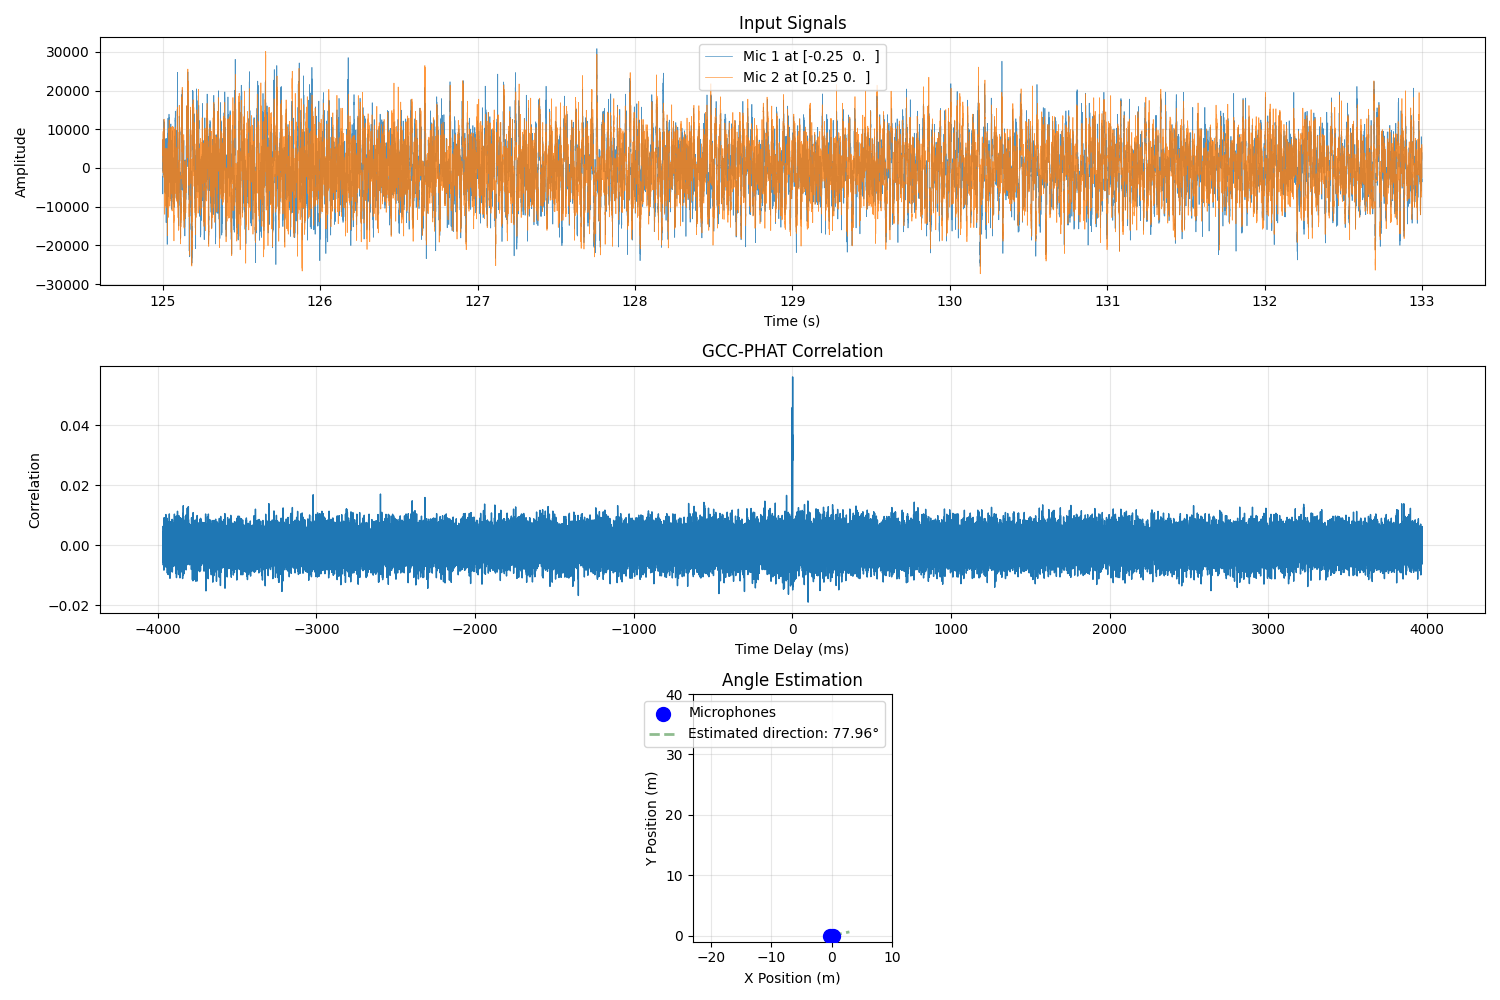


Note: 0° = straight ahead, positive = left, negative = right


In [453]:
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import correlation_lags

def calculate_tdoa_gcc_phat(mic1, mic2, t1, t2, sample_rate=8000):
    """
    Calculate TDoA using GCC-PHAT (Generalized Cross-Correlation with Phase Transform).
    More robust to noise and reverberation than standard cross-correlation or single-frequency methods.
    Works on the full broadband signal.
    
    Args:
        mic1: First Mic object
        mic2: Second Mic object
        t1: Start time in seconds
        t2: End time in seconds
        sample_rate: Sample rate in Hz (default 8000)
    
    Returns:
        tdoa: Time difference of arrival in seconds
        angle: Estimated angle in degrees
    """
    sd1 = mic1.get_sliced_data(t1, t2)
    sd2 = mic2.get_sliced_data(t1, t2)
    s1 = sd1[:, 1]
    s2 = sd2[:, 1]
    
    # Zero-pad to same length for FFT
    max_len = max(len(s1), len(s2))
    s1_padded = np.pad(s1, (0, max_len - len(s1)))
    s2_padded = np.pad(s2, (0, max_len - len(s2)))
    
    # Compute FFT
    fft1 = fft(s1_padded)
    fft2 = fft(s2_padded)
    
    # GCC-PHAT: normalize by magnitude (phase transform)
    # This emphasizes phase information and is robust to amplitude variations
    cross_spectrum = fft1 * np.conj(fft2)
    magnitude = np.abs(cross_spectrum)
    # Avoid division by zero
    magnitude[magnitude < 1e-10] = 1e-10
    cross_spectrum_phat = cross_spectrum / magnitude
    
    # Inverse FFT to get correlation (circular correlation)
    corr = np.real(ifft(cross_spectrum_phat))
    
    # For circular correlation, we need to fftshift to center it
    corr_shifted = np.fft.fftshift(corr)
    
    # Create lag indices for the shifted correlation (centered at zero)
    lag_samples = np.arange(len(corr_shifted)) - len(corr_shifted) // 2
    
    # Find peak correlation
    max_lag_idx = np.argmax(np.abs(corr_shifted))
    lag_samples_peak = lag_samples[max_lag_idx]
    
    # Convert lag from samples to time (seconds)
    tdoa = lag_samples_peak / sample_rate
    
    # Validate TDoA (must be physically possible)
    mic_separation = np.linalg.norm(mic2.pos - mic1.pos)
    speed_of_sound = 326  # speed of sound in m/s (updated from 343)
    max_tdoa = mic_separation / speed_of_sound
    tdoa = np.clip(tdoa, -max_tdoa, max_tdoa)
    
    # Calculate angle estimate (assuming mics are on x-axis, source is in 2D plane)
    # For far-field: sin(θ) = (c × TDoA) / d
    # where c is speed of sound, d is mic separation
    if mic_separation > 0:
        sin_theta = (speed_of_sound * tdoa) / mic_separation
        sin_theta = np.clip(sin_theta, -1, 1)  # Ensure valid range
        angle = np.arcsin(sin_theta) * 180 / np.pi  # Convert to degrees
    else:
        angle = 0
    
    return tdoa, angle


# Input time range for analysis


# Calculate TDoA and angle using GCC-PHAT
print(f"Calculating angle using GCC-PHAT for time window: {t_start:.2f}s to {t_end:.2f}s")
print("="*70)

tdoa, angle = calculate_tdoa_gcc_phat(
    mics_small[0], 
    mics_small[1], 
    t_start, 
    t_end, 
    SAMPLE_RATE
)

print(f"\nResults:")
print(f"  TDoA: {tdoa*1000:.3f} ms")
print(f"  Estimated angle: {angle:.2f}°")
print(f"  Mic separation: {np.linalg.norm(mics_small[1].pos - mics_small[0].pos):.3f} m")
print("="*70)

# Visualize the signals and correlation
sd1 = mics_small[0].get_sliced_data(t_start, t_end)
sd2 = mics_small[1].get_sliced_data(t_start, t_end)
s1 = sd1[:, 1]
s2 = sd2[:, 1]

# Compute GCC-PHAT for visualization
max_len = max(len(s1), len(s2))
s1_padded = np.pad(s1, (0, max_len - len(s1)))
s2_padded = np.pad(s2, (0, max_len - len(s2)))

fft1 = fft(s1_padded)
fft2 = fft(s2_padded)
cross_spectrum = fft1 * np.conj(fft2)
magnitude = np.abs(cross_spectrum)
magnitude[magnitude < 1e-10] = 1e-10
cross_spectrum_phat = cross_spectrum / magnitude
corr = np.real(ifft(cross_spectrum_phat))

# For circular correlation from FFT, we need to fftshift to center it
# and create matching lag indices
corr_shifted = np.fft.fftshift(corr)
# Create lag indices for the shifted correlation (centered at zero)
# Ensure the size matches corr_shifted exactly
lag_samples = np.arange(len(corr_shifted)) - len(corr_shifted) // 2
lag_times = lag_samples / SAMPLE_RATE

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Plot signals
t1_arr = sd1[:, 0]
t2_arr = sd2[:, 0]
axes[0].plot(t1_arr, s1, label=f'Mic 1 at {mics_small[0].pos}', alpha=0.8, linewidth=0.5)
axes[0].plot(t2_arr, s2, label=f'Mic 2 at {mics_small[1].pos}', alpha=0.8, linewidth=0.5)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Input Signals')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot GCC-PHAT correlation (use shifted version for proper lag display)
max_corr_idx = np.argmax(np.abs(corr_shifted))
peak_time_ms = lag_times[max_corr_idx] * 1000
print(f"Peak correlation time: {peak_time_ms:.2f} ms")
axes[1].plot(lag_times * 1000, corr_shifted, linewidth=1)
axes[1].set_xlabel('Time Delay (ms)')
axes[1].set_ylabel('Correlation')
axes[1].set_title('GCC-PHAT Correlation')
axes[1].grid(True, alpha=0.3)

# Plot angle visualization
mic_midpoint = (mics_small[0].pos + mics_small[1].pos) / 2
mic_positions = np.array([mics_small[0].pos, mics_small[1].pos])
axes[2].scatter(mic_positions[:, 0], mic_positions[:, 1], c='blue', s=100, label='Microphones', zorder=5)

# Draw estimated direction ray
angle_rad = angle * np.pi / 180
ray_length = 3.0
if mics_small[0].pos[0] < mics_small[1].pos[0]:
    dx = ray_length * np.sin(angle_rad)
    dy = ray_length * np.cos(angle_rad)
else:
    dx = -ray_length * np.sin(angle_rad)
    dy = ray_length * np.cos(angle_rad)

axes[2].plot([mic_midpoint[0], mic_midpoint[0] + dx], 
            [mic_midpoint[1], mic_midpoint[1] + dy], 
            'darkseagreen', linewidth=2, linestyle='dashed', 
            label=f'Estimated direction: {angle:.2f}°', zorder=3)
axes[2].set_xlabel('X Position (m)')
axes[2].set_ylabel('Y Position (m)')
axes[2].set_title('Angle Estimation')
axes[2].legend()
axes[2].set_aspect('equal')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(-23, 10)
axes[2].set_ylim(-1, 40)

plt.tight_layout()
plt.show()

print(f"\nNote: 0° = straight ahead, positive = left, negative = right")

In [454]:
# Plot points, squares, and angle guesses
fig, ax = plt.subplots(figsize=(10, 10))

# Plot red points
red_points = [(30, 0), (21.2, 15.2), (0, 30), (-21.2, 15.2), (-30, 0)]
red_x = [p[0] for p in red_points]
red_y = [p[1] for p in red_points]
ax.scatter(red_x, red_y, c='red', s=100, label='Points', zorder=5)



# Mic pair midpoint (assuming mics are at (-0.25, 0) and (0.25, 0) based on earlier code)
mic_midpoint = (0.0, 0.0)

# Plot angle guesses as rays from mic midpoint
angles = [78.43, 34.79, 4.7, -64.22, -74.78]
ray_length = 35.0

for angle in angles:
    # Convert angle to radians
    # 0° = straight ahead (positive y direction)
    # Negative angles = left, positive angles = right
    angle_rad = np.deg2rad(angle)
    
    # Calculate ray direction
    # For 0° = straight ahead (positive y), we use:
    # x = ray_length * sin(angle)
    # y = ray_length * cos(angle)
    dx = ray_length * np.sin(angle_rad)
    dy = ray_length * np.cos(angle_rad)
    
    # Plot ray from mic midpoint
    ax.plot([mic_midpoint[0], mic_midpoint[0] + dx], 
            [mic_midpoint[1], mic_midpoint[1] + dy], 
            'g--', linewidth=1.5, alpha=0.7, 
            label='Bearing estimation' if angle == angles[0] else '')
    
    # Add angle label near the end of the ray
    label_x = mic_midpoint[0] + dx * 0.9
    label_y = mic_midpoint[1] + dy * 0.9
    ax.text(label_x, label_y, f'{angle:.2f}°', fontsize=8, 
            ha='center', va='center', bbox=dict(boxstyle='round,pad=0.3', 
            facecolor='white', alpha=0.7))

# Plot mic positions for reference
ax.scatter([-0.25, 0.25], [, 0], c='black', marker='o', s=150, 
           label='Microphones', zorder=6)

ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_title('GCC PHAT Drone Angle Estimation')
ax.legend(loc='upper right')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlim(-40, 40)
ax.set_ylim(-1, 40)

plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (2515456465.py, line 46)

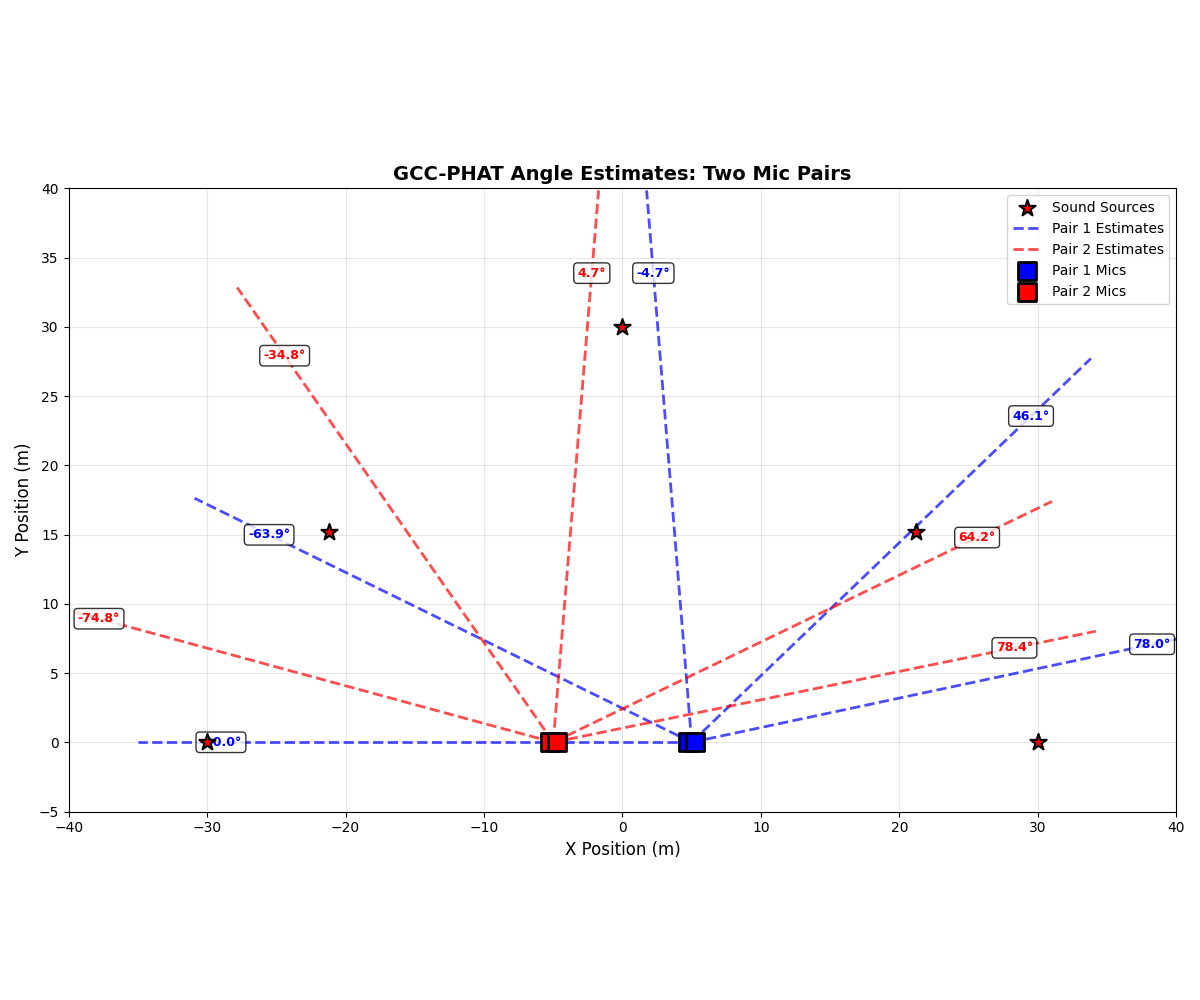

ANGLE COMPARISON
Source 1: Pair 1 =  77.98°, Pair 2 =  78.43°, Diff =  0.45°
Source 2: Pair 1 =  46.13°, Pair 2 =  64.22°, Diff = 18.09°
Source 3: Pair 1 =  -4.67°, Pair 2 =   4.70°, Diff =  9.37°
Source 4: Pair 1 = -63.85°, Pair 2 = -34.79°, Diff = 29.06°
Source 5: Pair 1 = -90.00°, Pair 2 = -74.78°, Diff = 15.22°


In [458]:
# ============================================================================
# INPUT: Angles and source positions
# ============================================================================
# Mic pair 1 angles (degrees)
angles_pair1 = [77.98, 46.13, -4.67, -63.85, -90]

# Mic pair 2 angles (degrees)  
angles_pair2 = [78.43, 64.22, 4.7, -34.79, -74.78]  # Example - replace with actual

# Sound source positions
source_points = [(30, 0), (21.2, 15.2), (0, 30), (-21.2, 15.2), (-30, 0)]

# Mic pair positions
pair1_midpoint = (5.0, 0.0)   # Pair 1 center at (5, 0)
pair2_midpoint = (-5.0, 0.0)  # Pair 2 center at (-5, 0)
mic_spacing = 0.5  # 50 cm spacing
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Plot source points
source_x = [p[0] for p in source_points]
source_y = [p[1] for p in source_points]
ax.scatter(source_x, source_y, c='red', s=150, marker='*', 
           label='Sound Sources', zorder=5, edgecolors='black', linewidth=1.5)

# Plot angle rays for Pair 1 (BLUE)
ray_length = 40.0
for i, angle in enumerate(angles_pair1):
    angle_rad = np.deg2rad(angle)
    # 0° = straight ahead (positive y direction)
    # x = ray_length * sin(angle), y = ray_length * cos(angle)
    dx = ray_length * np.sin(angle_rad)
    dy = ray_length * np.cos(angle_rad)
    
    # Plot ray from pair 1 midpoint
    ax.plot([pair1_midpoint[0], pair1_midpoint[0] + dx],
            [pair1_midpoint[1], pair1_midpoint[1] + dy],
            'b--', linewidth=2, alpha=0.7,
            label='Pair 1 Estimates' if i == 0 else '')
    
    # Add angle label
    label_x = pair1_midpoint[0] + dx * 0.85
    label_y = pair1_midpoint[1] + dy * 0.85
    ax.text(label_x, label_y, f'{angle:.1f}°', fontsize=9,
            ha='center', va='center', color='blue', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Plot angle rays for Pair 2 (RED)
for i, angle in enumerate(angles_pair2):
    angle_rad = np.deg2rad(angle)
    dx = ray_length * np.sin(angle_rad)
    dy = ray_length * np.cos(angle_rad)
    
    # Plot ray from pair 2 midpoint
    ax.plot([pair2_midpoint[0], pair2_midpoint[0] + dx],
            [pair2_midpoint[1], pair2_midpoint[1] + dy],
            'r--', linewidth=2, alpha=0.7,
            label='Pair 2 Estimates' if i == 0 else '')
    
    # Add angle label
    label_x = pair2_midpoint[0] + dx * 0.85
    label_y = pair2_midpoint[1] + dy * 0.85
    ax.text(label_x, label_y, f'{angle:.1f}°', fontsize=9,
            ha='center', va='center', color='red', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Plot mic positions for Pair 1 (blue)
pair1_left = (pair1_midpoint[0] - mic_spacing/2, pair1_midpoint[1])
pair1_right = (pair1_midpoint[0] + mic_spacing/2, pair1_midpoint[1])
ax.scatter([pair1_left[0], pair1_right[0]], [pair1_left[1], pair1_right[1]],
           c='blue', marker='s', s=150, label='Pair 1 Mics', zorder=6,
           edgecolors='black', linewidth=2)

# Plot mic positions for Pair 2 (red)
pair2_left = (pair2_midpoint[0] - mic_spacing/2, pair2_midpoint[1])
pair2_right = (pair2_midpoint[0] + mic_spacing/2, pair2_midpoint[1])
ax.scatter([pair2_left[0], pair2_right[0]], [pair2_left[1], pair2_right[1]],
           c='red', marker='s', s=150, label='Pair 2 Mics', zorder=6,
           edgecolors='black', linewidth=2)

# Formatting
ax.set_xlabel('X Position (m)', fontsize=12)
ax.set_ylabel('Y Position (m)', fontsize=12)
ax.set_title('GCC-PHAT Angle Estimates: Two Mic Pairs', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlim(-40, 40)
ax.set_ylim(-5, 40)

plt.tight_layout()
plt.show()

# Print angle comparison
print("="*80)
print("ANGLE COMPARISON")
print("="*80)
for i in range(min(len(angles_pair1), len(angles_pair2))):
    diff = abs(angles_pair1[i] - angles_pair2[i])
    print(f"Source {i+1}: Pair 1 = {angles_pair1[i]:6.2f}°, Pair 2 = {angles_pair2[i]:6.2f}°, Diff = {diff:5.2f}°")
print("="*80)